# GOES-16 Fire Temperature Recipe
__Brian Blaylock__  
__May 21, 2018__  

This notebook shows how to make the GOES-16 Fire Product

## Download GOES-16 Data
For this demo, you'll need a GOES-16 data file. I created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi) to easily download files from [NOAA's Amazon S3 GOES Archive](https://aws.amazon.com/public-datasets/goes/).

To get started, you will need a __CONUS__ file in the __multiband format__. 

http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0

These level 2 files contains all 16 bands on the same 2 km resolution over the contiguous United States. Some additional work, not described here, is needed if you want the full 1 km resolution true color images (i.e. need to download three separate files for each RGB channels and subsample the red channel because of its 0.5 km resolution).

----------

### First, import some libraries we will use

In [100]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
from netCDF4 import Dataset
import numpy as np
from pyproj import Proj                  # Note to self: pyproj not installed on meteo19.
                                         # Run notebook on meso4 or from desktop.

### Read in the file
The GOES-16 data is in NetCDF format. A description of what the file's name means can be found on [Amazon's page](https://aws.amazon.com/public-datasets/goes/).

In [101]:
C_file = 'V:/Pando/GOES16/ABI-L2-MCMIPC/20180521/OR_ABI-L2-MCMIPC-M3_G16_s20181410002234_e20181410005007_c20181410005118.nc'
C = Dataset(C_file, 'r')

### Get the RGB values for a true color image
I followed the instructions [here](http://edc.occ-data.org/goes16/python/) for applying a gamma correction and calculating the "true green" value.

If needed, you can get the specific wavelengths of each band or channel. For example, `C.variables['band_wavelength_C01'][0]` is the wavelength of channel 1 (visible blue).

In [102]:
# Load the RGB arrays and apply a gamma correction (square root)
R = np.sqrt(C.variables['CMI_C07'][:].data) # Band 7 is red (0.3.9 um, shortwave)
G = np.sqrt(C.variables['CMI_C06'][:].data) # Band 6 is "green" (0.2.2 um, cloud particle)
B = np.sqrt(C.variables['CMI_C05'][:].data) # Band 5 is blue (0.1.6 um, snow/ice)

# The final RGB array :)
RGB = np.dstack([R, G, B])

RuntimeError: NetCDF: HDF error

Get date information: The midpoint of the begining and ending of the scan time

In [98]:
# Seconds since 2000-01-01 12:00:00
add_seconds = C.variables['t'][0]
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

In [99]:
C.variables['t'][0]

580133022.11920094

We can easliy plot the this image so we can see what it looks like.

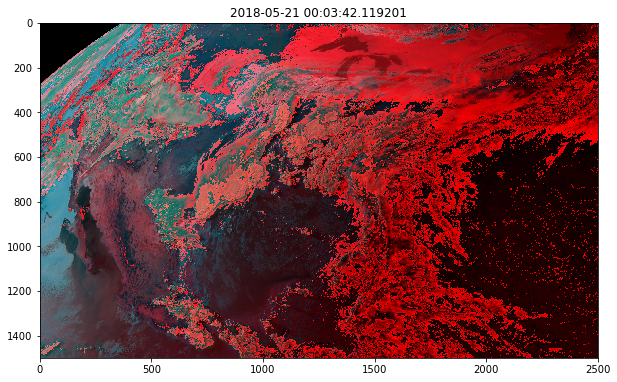

In [6]:
plt.figure(figsize=[10, 8])
plt.imshow(RGB)
plt.title(DATE)

### Plot GOES-16 on a Basemap
The problem with the above image is that it is not georeferenced. We do not know where in the world each pixel lies. The GOES-16 file contains all the metadata needed to understand the map projection of the image. We will use this data to plot the image on a basemap. The data is in a [geostationary projection](http://proj4.org/projections/geos.html).

In [7]:
C.variables['goes_imager_projection']

<type 'netCDF4._netCDF4.Variable'>
int32 goes_imager_projection()
    long_name: GOES-R ABI fixed grid projection
    grid_mapping_name: geostationary
    perspective_point_height: 35786023.0
    semi_major_axis: 6378137.0
    semi_minor_axis: 6356752.31414
    inverse_flattening: 298.2572221
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: -75.0
    sweep_angle_axis: x
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

Get a few variables needed to create map projection object and create the pyproj object.

In [8]:
# Satellite height
sat_h = C.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

In [9]:
Y.max()

4588198.0

With the projection data, we can plot the satellite imagry on a Basemap.

#### Geostationary Basemap

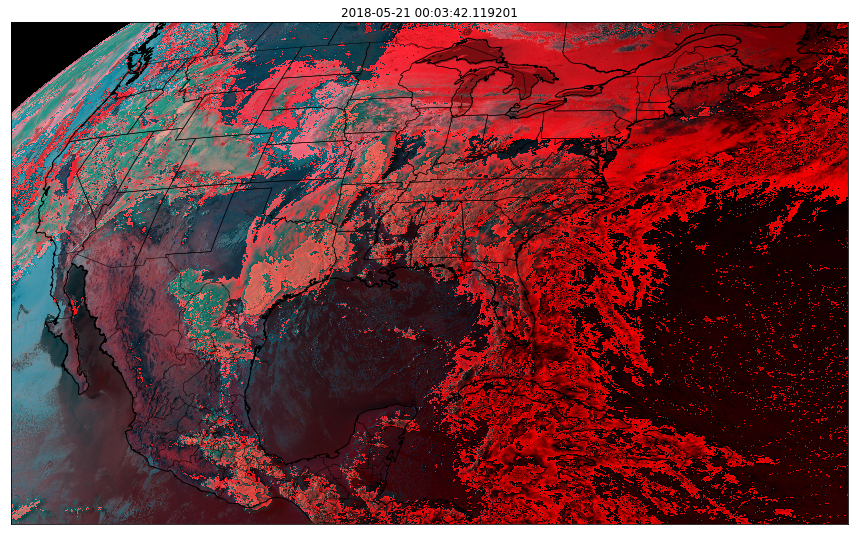

In [35]:
# The geostationary projection is perhaps the easiest way, and we don't need to use the Proj object.
# Essentially, we are stretching the image across a map with the same projection and dimensions.
plt.figure(figsize=[15, 12])
m = Basemap(projection='geos', lon_0=sat_lon,
            resolution='i', area_thresh=10000,
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())
m.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines()
m.drawcountries()
m.drawstates()
plt.title(DATE)

#### Lambert Conformal Projection
To project the GOES-16 data onto a new map we need to get the latitude and longitude of every point in the data. We can do this by using an inverse transformation of the map projection object, `p`, of the map coordinates given by X and Y. I am going to project the GOES-16 data on the Lambert Conformal Projection used by the [HRRR](https://rapidrefresh.noaa.gov/hrrr/) model.

#### The magic function: `pyproj.Proj`
This function creates a map projection object of the geostationary projection.

In [21]:
# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

In [22]:
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

In [23]:
# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=1500, \
            width=1800*3000, height=1060*3000, \
            lat_1=38.5, lat_2=38.5, \
            lat_0=38.5, lon_0=-97.5)

xH, yH = mH(lons, lats)

We can't simply plot the reprojected image with `imshow` because the pixels are spaced irregularly. We have to use `pcolormesh`, which is not a trivial task. We need to create a color tuple for each pixel. Details on doing this are on stackoverflow [here](https://stackoverflow.com/questions/29232439/plotting-an-irregularly-spaced-rgb-image-in-python) and [here](https://stackoverflow.com/questions/41389335/how-to-plot-geolocated-rgb-data-faster-using-python-basemap). Below is my method.

In [24]:
# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
rgb = np.minimum(rgb, 1) # Force the maximum possible RGB value to be 1 (the lowest should be 0).
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster?? according to stackoverflow.

C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in minimum
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
R

array([[         nan,          nan,          nan, ...,  15.4365778 ,
         15.53215027,  15.65727806],
       [         nan,          nan,          nan, ...,  15.34638596,
         15.49585152,  15.56583977],
       [         nan,          nan,          nan, ...,  15.39324951,
         15.47682381,  15.53215027],
       ..., 
       [ 17.28598785,  17.29621315,  17.32458305, ...,  17.24047089,
         17.23895264,  17.23629189],
       [ 17.29734802,  17.28106308,  17.30378342, ...,  17.24047089,
         17.24047089,  17.23895264],
       [ 17.32458305,  17.27462006,  17.2693119 , ...,  17.23629189,
         17.23781204,  17.23781204]], dtype=float32)

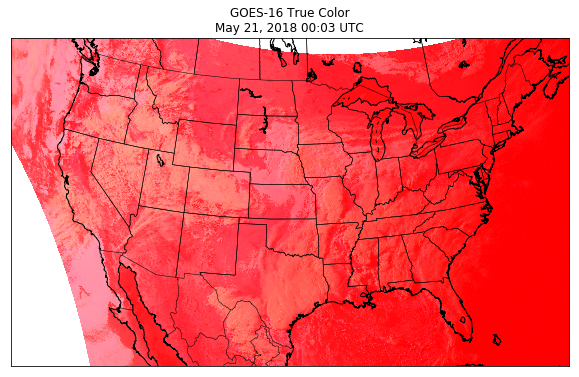

In [16]:
# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[10, 8])

# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mH.pcolormesh(xH, yH, G, color=colorTuple, linewidth=0)
newmap.set_array(None) # without this line, the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

plt.title('GOES-16 True Color\n%s' % DATE.strftime('%B %d, %Y %H:%M UTC'))

# Fire Temperature Recipe from Chad Gravelle (chad.gravell@noaa.gov)

R: 3.9 µm brightness temperature [273-333 K] with a gamma correction of 0.4

G: 2.25 µm reflectance [0 - 1] 

B: 1.6 µm reflectance [0 - 0.75]  

The 2.2 and 1.6 µm should be reflectance...with the 3.9 µm in K. Is that what you're seeing?

In [82]:
R = C.variables['CMI_C07'][:].data # Band 7 is red (0.3.9 um, shortwave)
R[R==-1] = np.nan
# Normalize R
R = (R-273)/(333-273)
# Gamma correct R
R = R^(0.4)

G = C.variables['CMI_C06'][:].data # Band 6 is "green" (0.2.2 um, cloud particle)
G[G==-1] = np.nan

B = C.variables['CMI_C05'][:].data # Band 5 is blue (0.1.6 um, snow/ice)
B[B==-1] = np.nan


RuntimeError: NetCDF: HDF error

In [93]:
C.variables['CMI_C07'][:]

RuntimeError: NetCDF: HDF error